# Import of dataset and libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate
import warnings
import scipy.stats as stats
from numpy import mean
from numpy import std
from imblearn.combine import SMOTEENN


In [ ]:
# Importing dataset
df = pd.read_csv("fetal_health.csv")

# Separating features (X) and target variable (y)
X = df.drop(['fetal_health'], axis=1)
y = df['fetal_health']

# Divide data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)

# Combine X_train and y_train into a single DataFrame (df_train)
df_train = pd.concat([X_train, y_train], axis=1)

# Combine X_test and y_test into a single DataFrame (df_test)
df_test = pd.concat([X_test, y_test], axis=1)


# Exploratory Data Analysis

## Dataset Description

Features

    'baseline value' FHR baseline (beats per minute)
    'accelerations' Number of accelerations per second
    'fetal_movement' Number of fetal movements per second
    'uterine_contractions' Number of uterine contractions per second
    'light_decelerations' Number of light decelerations per second
    'severe_decelerations' Number of severe decelerations per second
    'prolongued_decelerations' Number of prolonged decelerations per second
    'abnormal_short_term_variability' Percentage of time with abnormal short term variability
    'mean_value_of_short_term_variability' Mean value of short term variability
    'percentage_of_time_with_abnormal_long_term_variability' Percentage of time with abnormal long term variability
    'mean_value_of_long_term_variability' Mean value of long term variability
    'histogram_width' Width of FHR histogram
    'histogram_min' Minimum (low frequency) of FHR histogram
    'histogram_max' Maximum (high frequency) of FHR histogram
    'histogram_number_of_peaks' Number of histogram peaks
    'histogram_number_of_zeroes' Number of histogram zeros
    'histogram_mode' Histogram mode
    'histogram_mean' Histogram mean
    'histogram_median' Histogram median
    'histogram_variance' Histogram variance
    'histogram_tendency' Histogram tendency

    Target
    'fetal_health' Tagged as 1 (Normal), 2 (Suspect) and 3 (Pathological)


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


In [ ]:
#showing dataframe info
nan_values = X_train.isna().sum()
null_values = X_train.isnull().sum()

values_nan_null = [[X_train.columns[i], nan_values[i], null_values[i]] for i in range(0, len(nan_values))]
table = tabulate(values_nan_null, headers=['Feature', 'Nan Count', 'Null Count'], tablefmt='pretty')
print(table)

+--------------------------------------------------------+-----------+------------+
|                        Feature                         | Nan Count | Null Count |
+--------------------------------------------------------+-----------+------------+
|                     baseline value                     |     0     |     0      |
|                     accelerations                      |     0     |     0      |
|                     fetal_movement                     |     0     |     0      |
|                  uterine_contractions                  |     0     |     0      |
|                  light_decelerations                   |     0     |     0      |
|                  severe_decelerations                  |     0     |     0      |
|                prolongued_decelerations                |     0     |     0      |
|            abnormal_short_term_variability             |     0     |     0      |
|          mean_value_of_short_term_variability          |     0     |     0

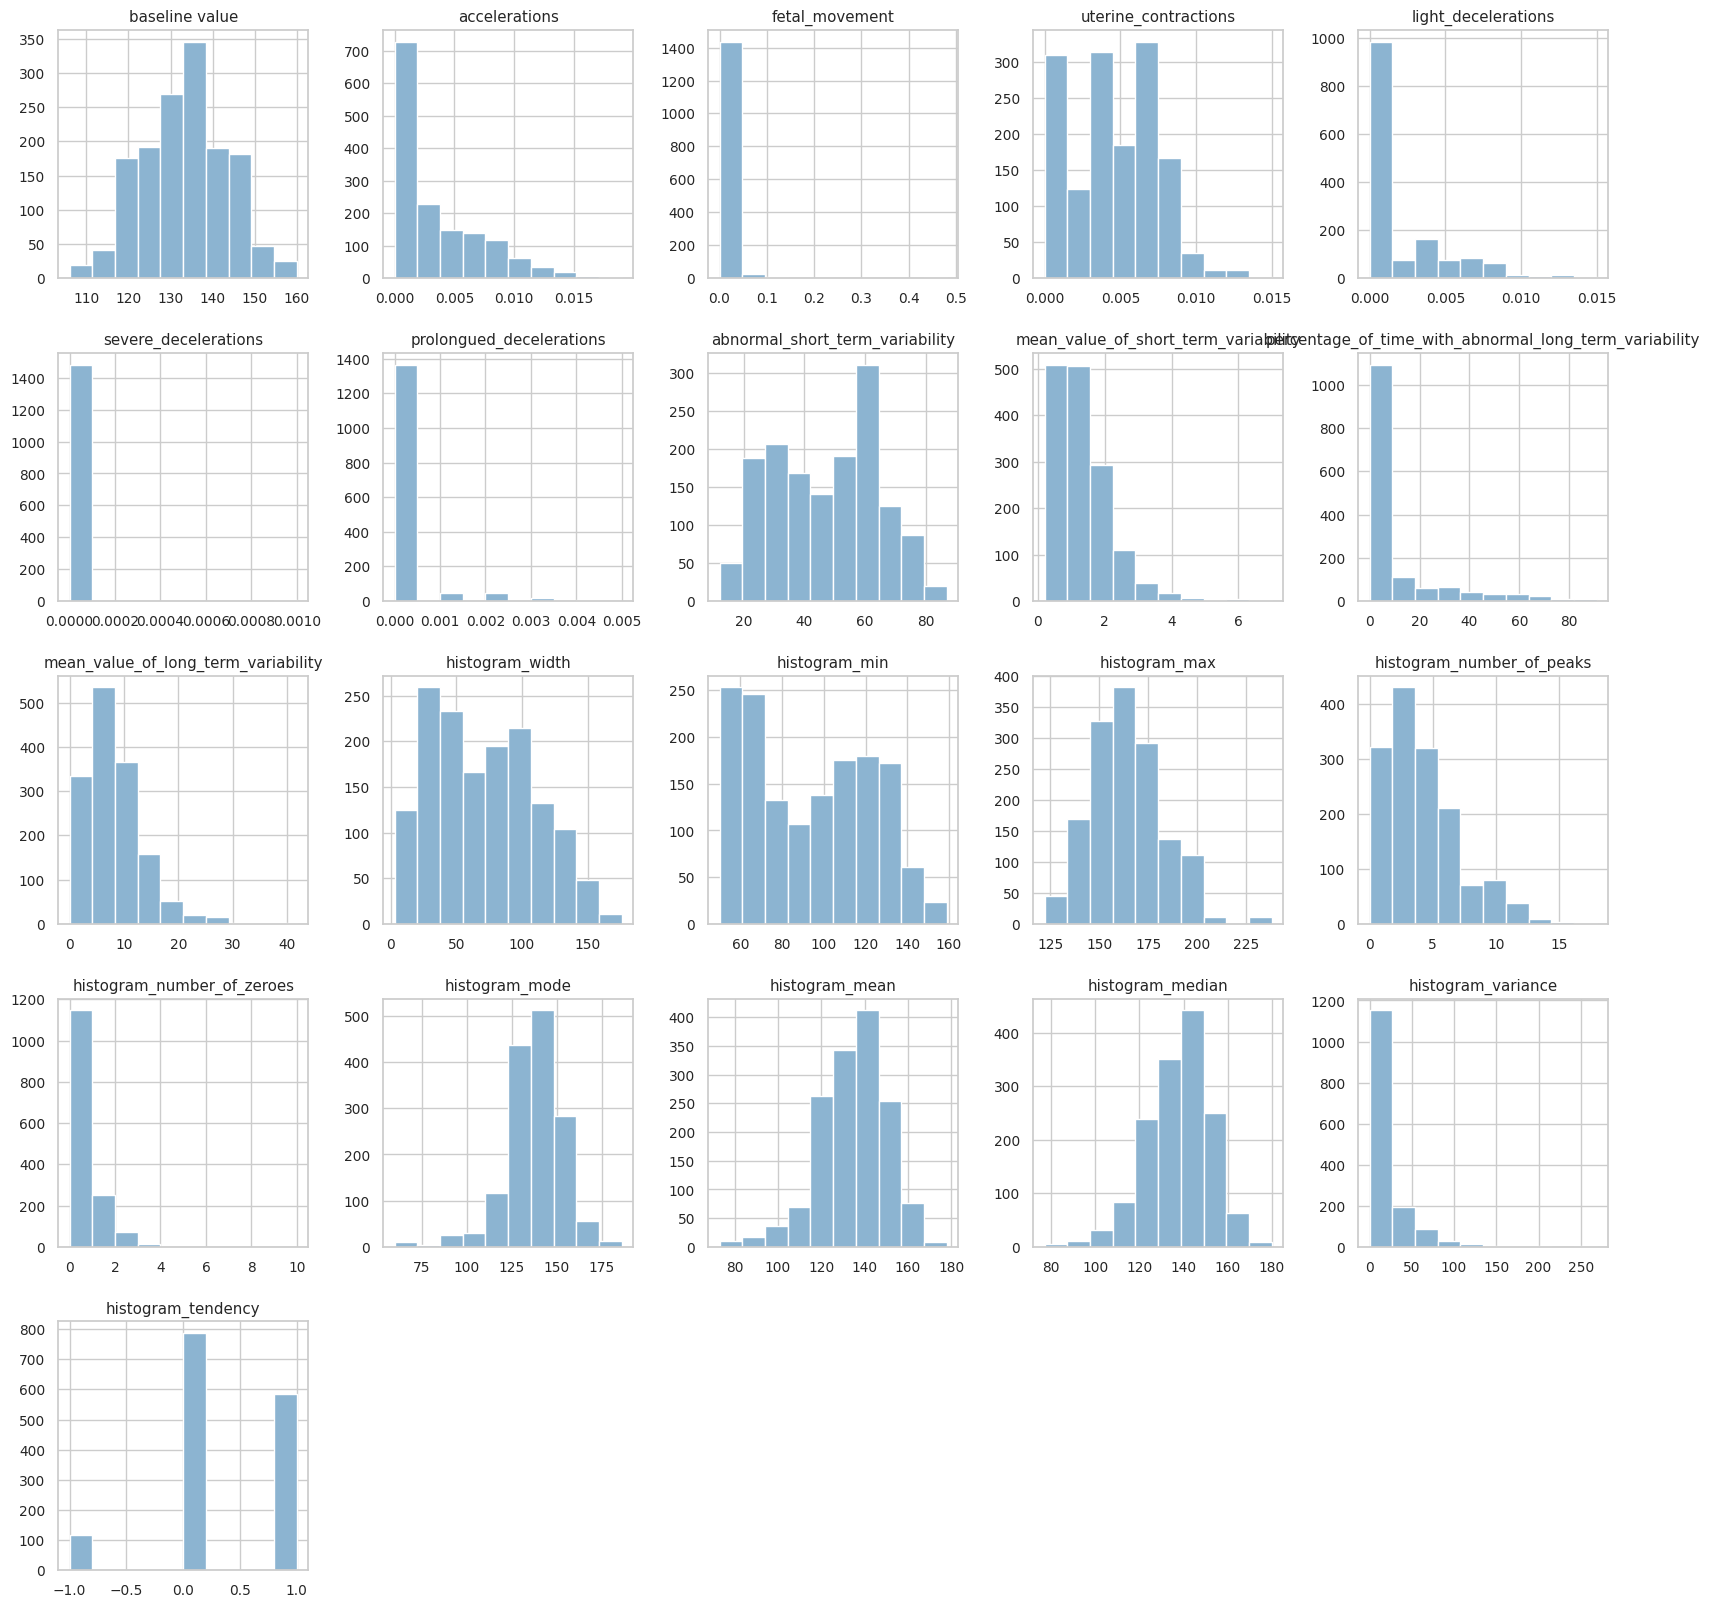

In [ ]:
data_hist_plot = X_train.hist(figsize = (20,20))

In [ ]:
statistic_table = []

for feature in X_train.columns:
    stat, p_value = shapiro(X_train[feature])
    new_row = [feature, stat, p_value]
    statistic_table.append(new_row)

print(tabulate(statistic_table, headers=['Feature', 'Stat', 'P-value'], floatfmt=(".4f", ".4f", ".4f"), tablefmt='pretty'))

+--------------------------------------------------------+----------------------+------------------------+
|                        Feature                         |         Stat         |        P-value         |
+--------------------------------------------------------+----------------------+------------------------+
|                     baseline value                     |  0.9941352605819702  | 1.3236907761893235e-05 |
|                     accelerations                      |  0.8111568093299866  | 1.4041733682542259e-38 |
|                     fetal_movement                     |  0.1901313066482544  |          0.0           |
|                  uterine_contractions                  |  0.957732617855072   | 2.3535089806787928e-20 |
|                  light_decelerations                   |  0.6943365931510925  | 1.401298464324817e-45  |
|                  severe_decelerations                  | 0.030892133712768555 |          0.0           |
|                prolongued_decelerat

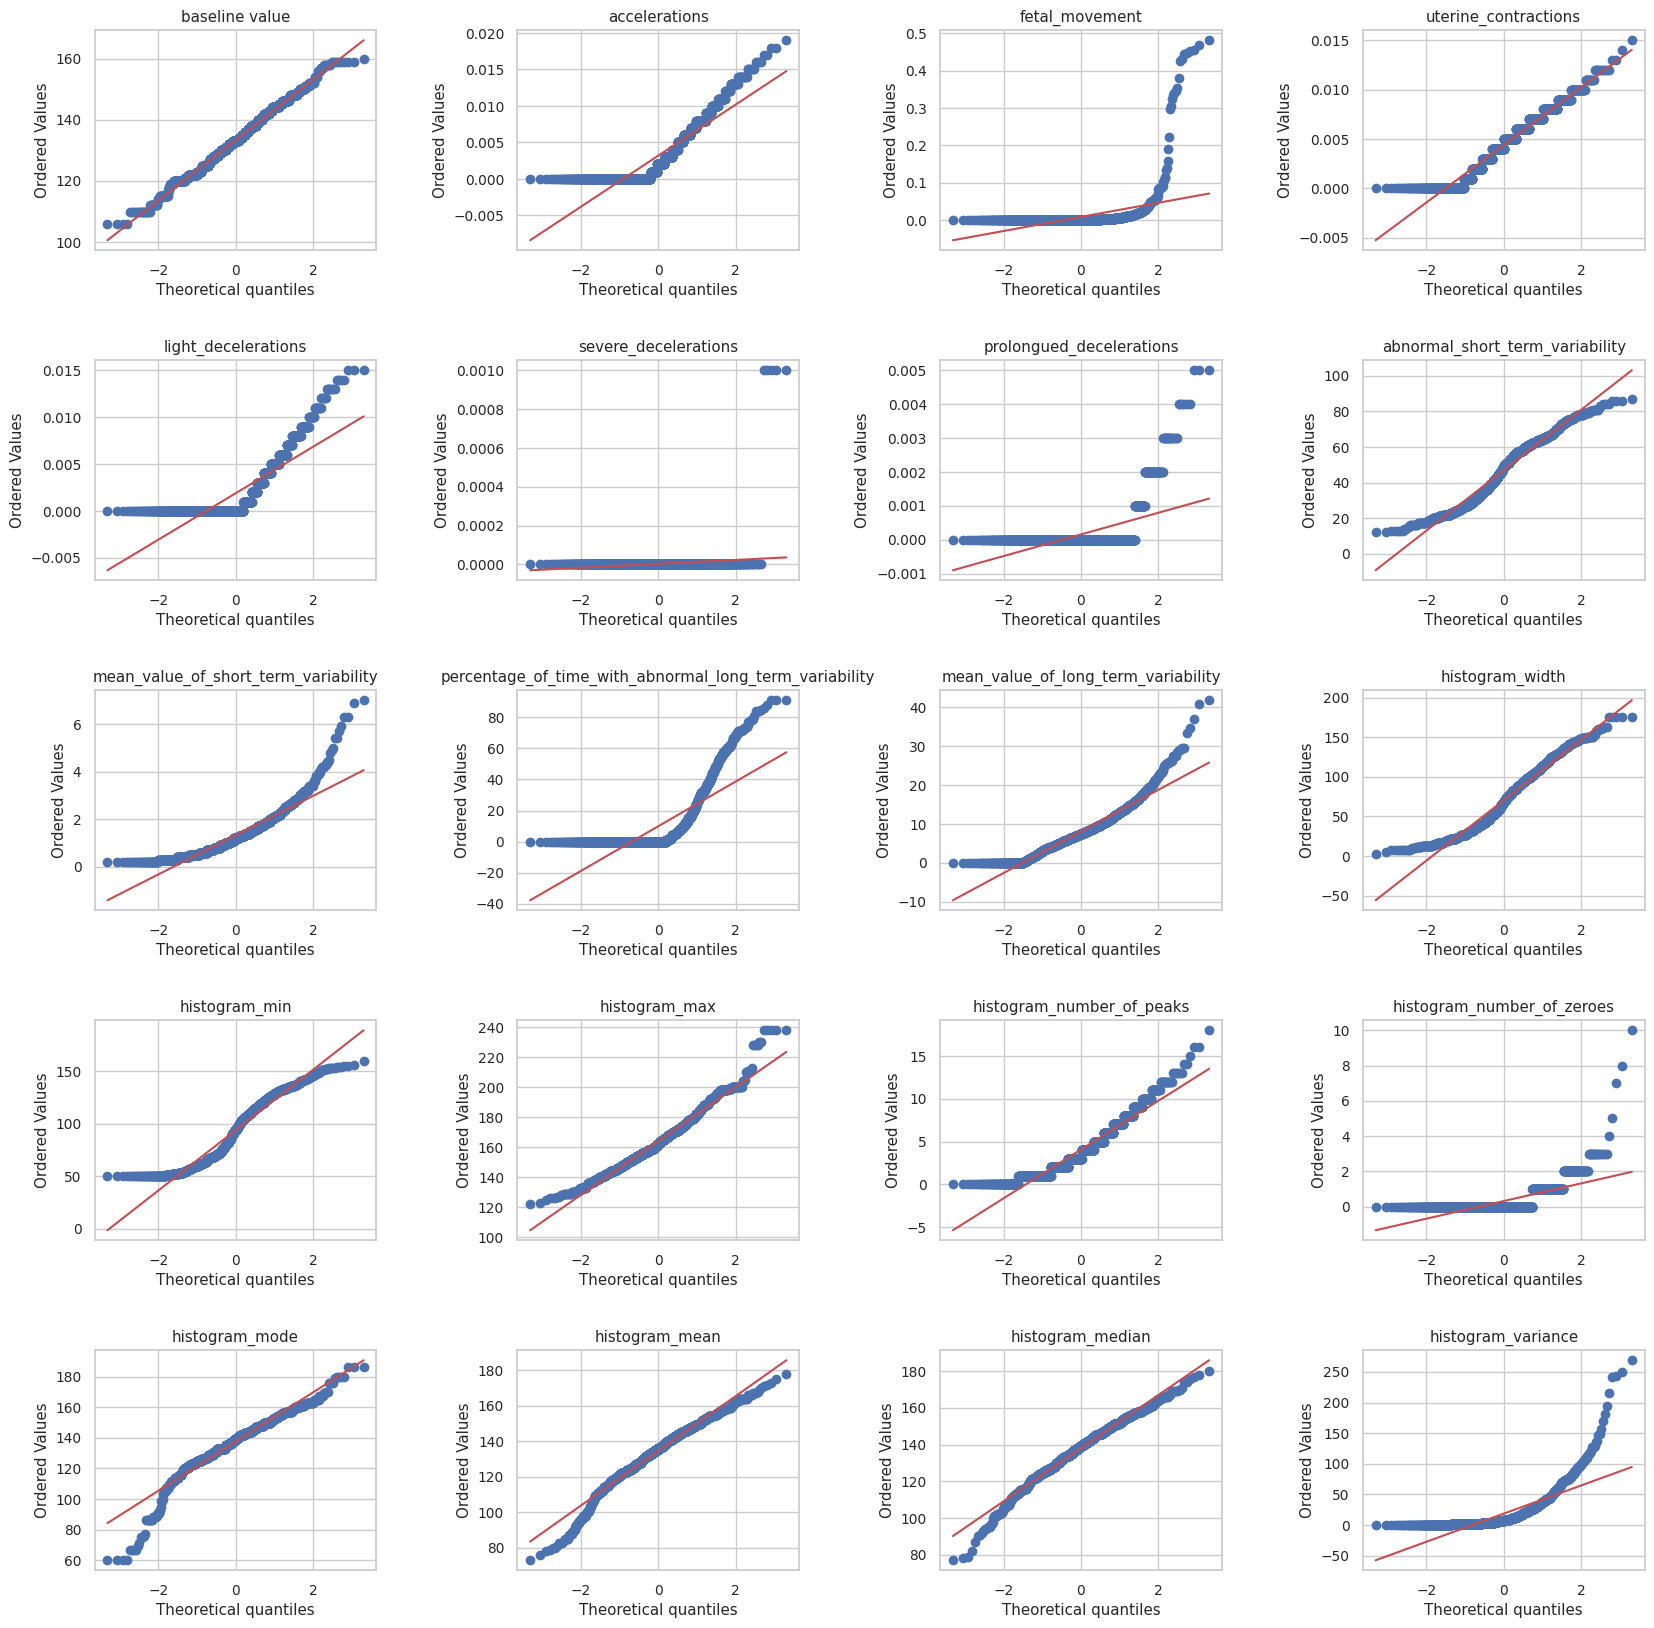

In [ ]:
# Specify the theoretical distribution (in the case of a normal distribution)
theoretical = stats.norm

# Create a 5x4 grid of plots
fig, axs = plt.subplots(5, 4, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spaces between plots

for ax, feature in zip(axs.ravel(), X_train.columns):
    stats.probplot(X_train[feature], plot=ax, dist=theoretical)
    ax.set_title(feature)  # Add the feature name as the title
    ax.margins(0.05)  # Add margins to individual axes

plt.show()


## Class Distribution in the Dataset

It is evident that the dataset exhibits a significant imbalance, as there is a pronounced prevalence of data related to individuals in good health. This imbalance is a common issue in medical datasets, as collecting data from healthy individuals is often easier than from those who are ill.

This disparity could negatively impact the model training, introducing a bias that compromises the accuracy in classifying minority classes. Since our primary interest lies in correctly identifying cases of illness or suspicion, addressing this challenge is crucial to ensure reliable and unbiased results in classification.

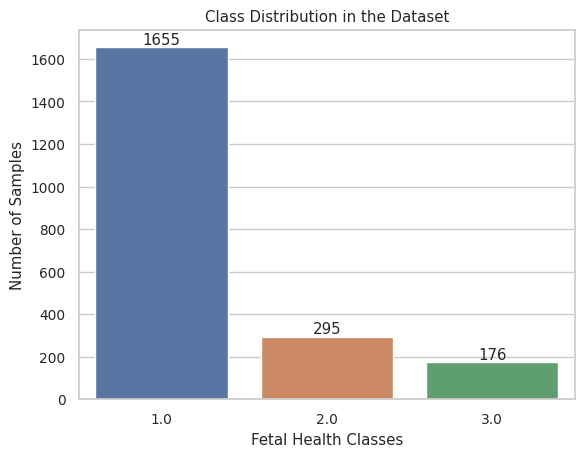

In [ ]:
ax = sns.countplot(data= df, x = 'fetal_health',palette='deep')
ax.bar_label(ax.containers[0])
plt.xlabel('Fetal Health Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Dataset')
plt.savefig('Distribution Plot.svg')
plt.show()

## Correlation Analysis

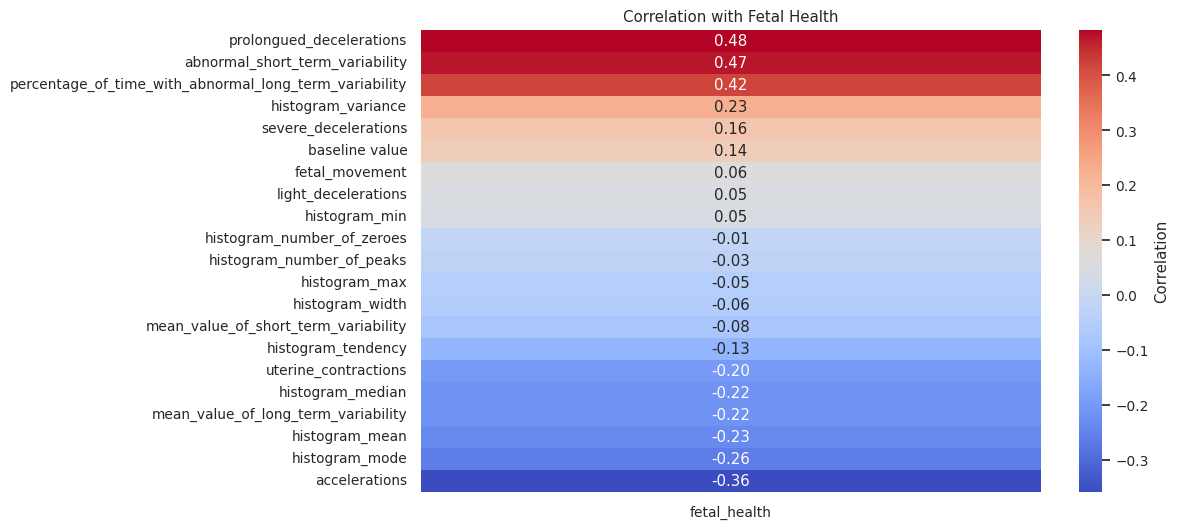

In [ ]:
# Create a heatmap of the correlations with the target column
corr = df_train.corr()
target_corr = corr['fetal_health'].drop('fetal_health')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.9)
sns.set_style("whitegrid")  # Change from "white" to "whitegrid" for better visibility
sns.set_palette("PuBuGn_d")
plt.figure(figsize=(10, 6))  # Set a specific figure size for better clarity

# Use a diverging color map for better readability
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f', cbar_kws={'label': 'Correlation'})

plt.title('Correlation with Fetal Health')
plt.savefig("Correlation_Plot.png")  # Save the plot with a corrected file name
plt.show()

## Box-Plot

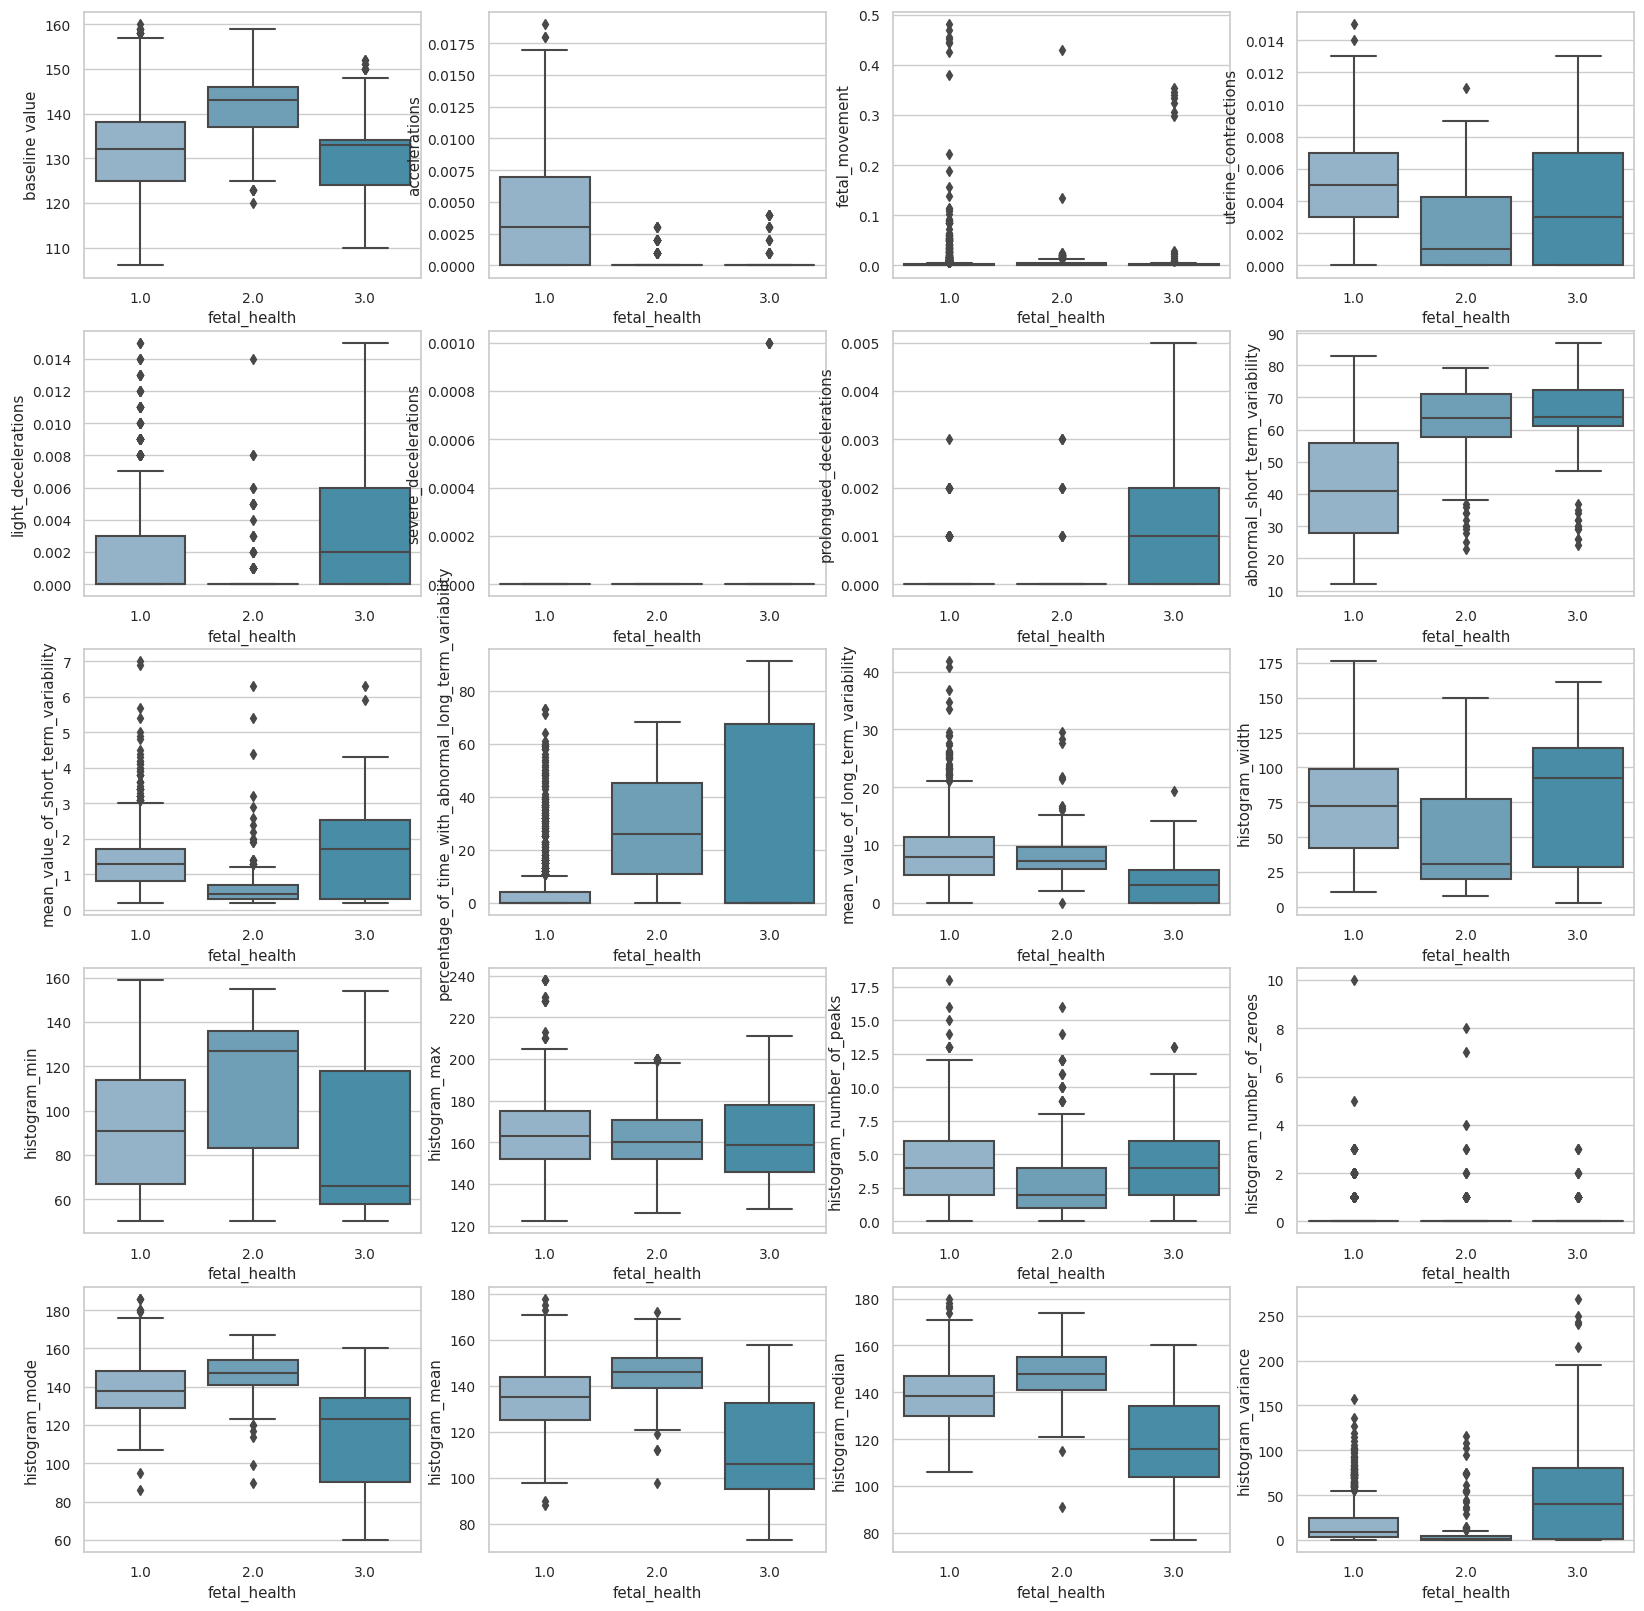

In [ ]:
features = X_train.columns
target_feature = "fetal_health"
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

i = 0
for feature in features:
    if i < len(axes):
        ax = sns.boxplot(x=target_feature, y=feature, data=df_train, ax=axes[i])
        i += 1
    else:
        break

# Dataset Preprocessing

## Outliers Remotion

Since a very low p-value is observed for each variable, it cannot be claimed that they follow a Gaussian distribution. Therefore, for the removal of outliers, Minimum Covariance Determinant cannot be used

A IsolationForest operation is used to identify and remove outliers from the dataset.

Notably, we took the careful approach of treating the three classes separately. This distinction is crucial because what may be considered normal physiological values for a fetus with health issues may differ significantly from those of a healthy patient.

In [ ]:

def clean_df_IsolationForest(df, labels_feature, nu_value):
    df_cleaned_list = []
    total_value = len(df)
    removed_rows_count = 0  # Counter for removed rows

    grouped_df = df.groupby(labels_feature)
    for label in df[labels_feature].unique():

        sub_df = grouped_df.get_group(label)
        # identify outliers in the training dataset
        iso = IsolationForest(contamination=0.1)
        yhat = iso.fit_predict(sub_df.drop(labels_feature, axis=1))
        # select all rows that are not outliers
        mask = yhat != -1
        removed_rows_count += len(sub_df) - sum(mask)  # Update the counter
        cleaned_sub_df = sub_df.loc[mask, :].copy()  # Use .copy() to avoid SettingWithCopyWarning
        df_cleaned_list.append(cleaned_sub_df)

        print(f'Removal for class {label}: {len(sub_df) - sum(mask)} rows removed out of {len(sub_df)}.')

    print(f'Total rows removed: {removed_rows_count} out of {total_value}')
    return pd.concat(df_cleaned_list, ignore_index=True)



df_train = clean_df_IsolationForest(df_train, 'fetal_health', 0.1)

# Split the cleaned DataFrame into X_train and y_train
X_train = df_train.drop('fetal_health', axis=1)
y_train = df_train['fetal_health']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Removal for class 1.0: 117 rows removed out of 1164.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Removal for class 2.0: 21 rows removed out of 204.
Removal for class 3.0: 12 rows removed out of 120.
Total rows removed: 150 out of 1488


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


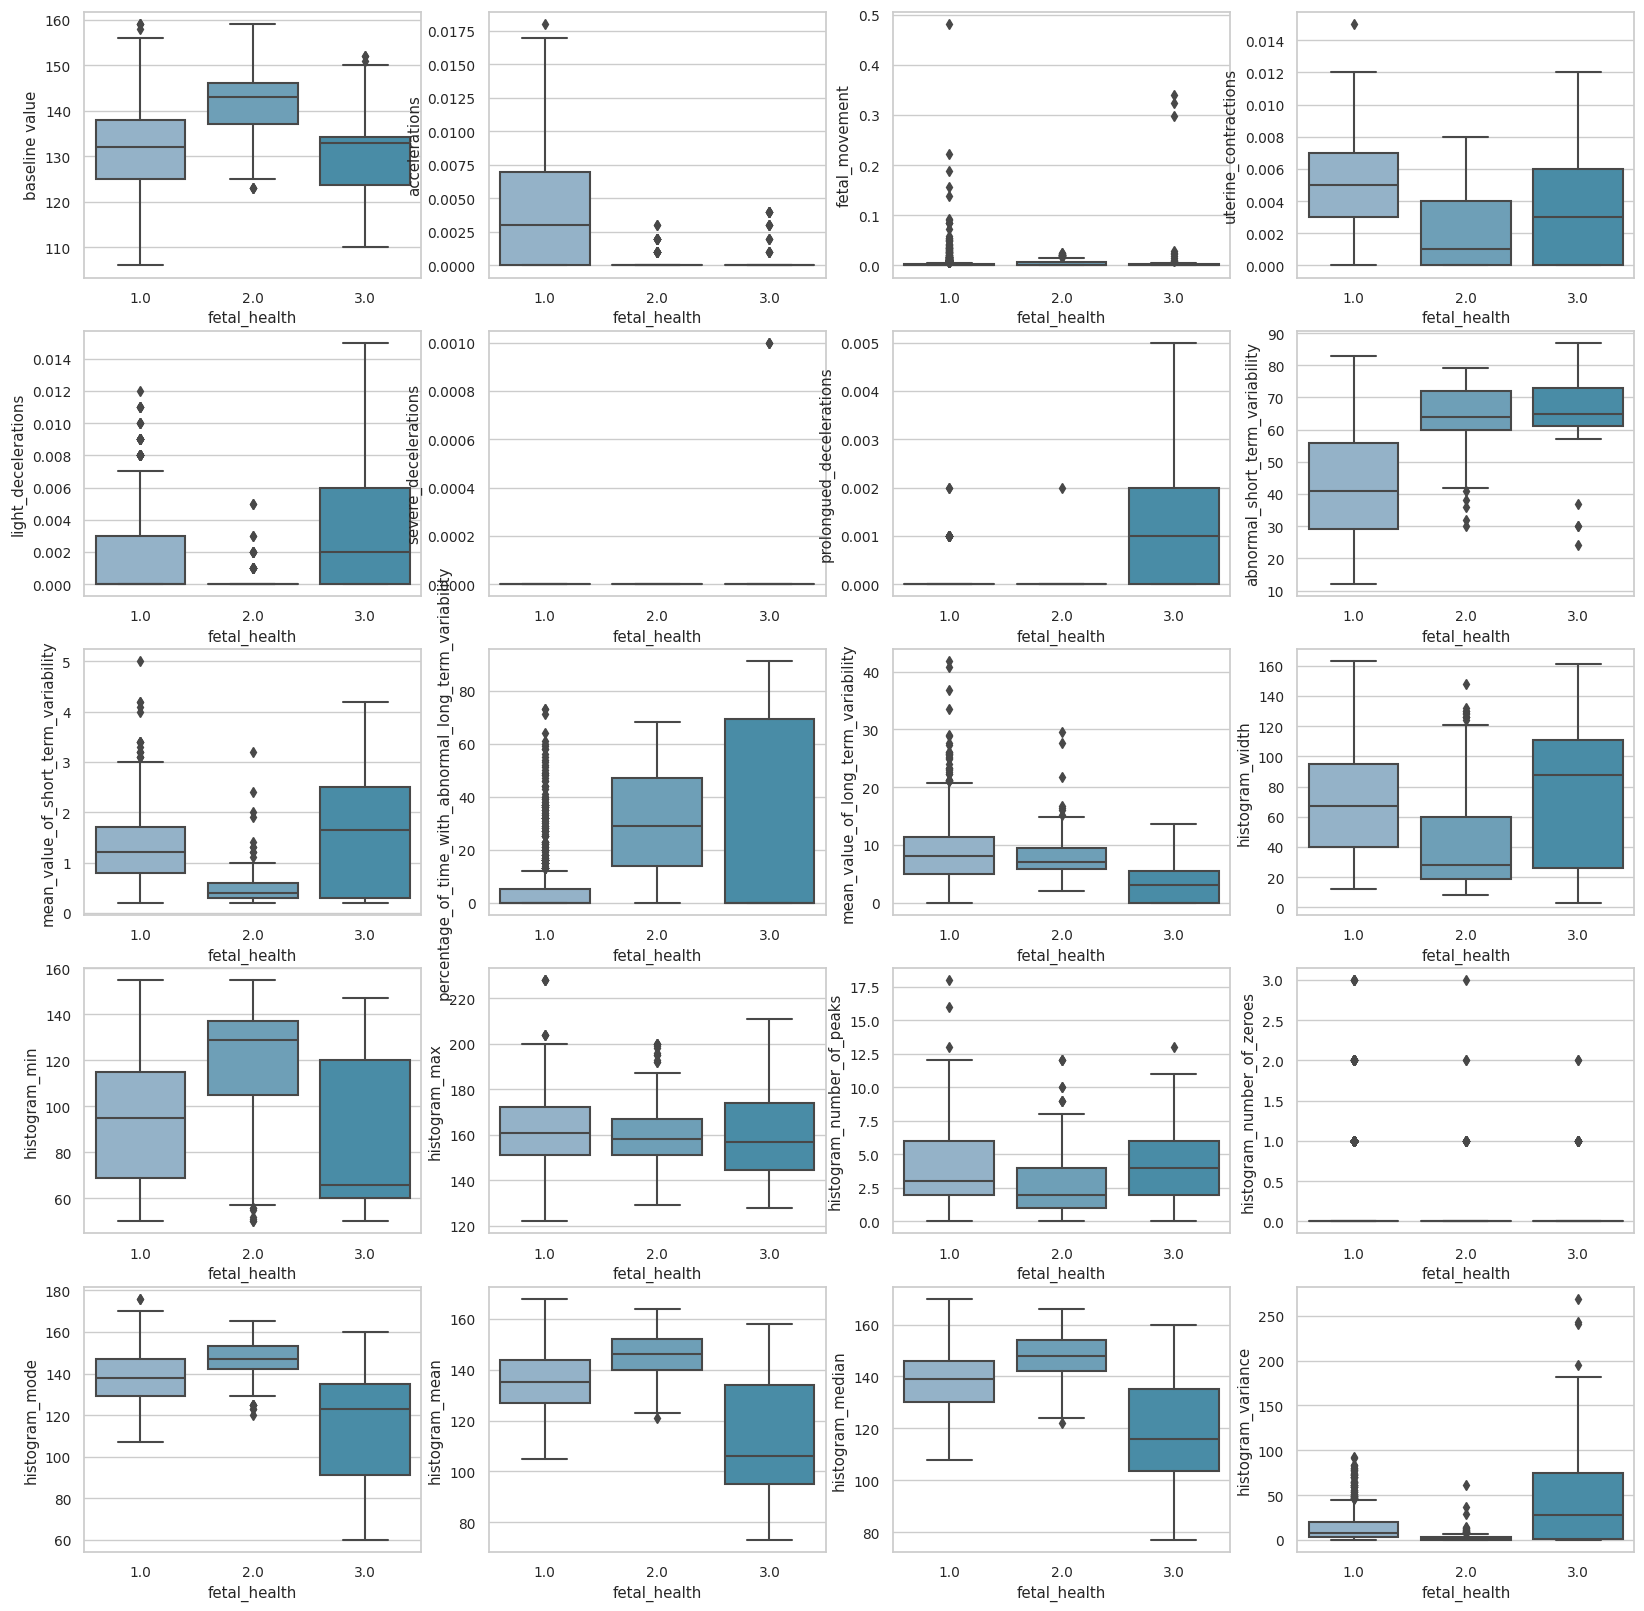

In [ ]:
features = X_train.columns
target_feature = "fetal_health"
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

i = 0
for feature in features:
    if i < len(axes):
        ax = sns.boxplot(x=target_feature, y=feature, data=df_train, ax=axes[i])
        i += 1
    else:
        break

## SMOTE + ENN Algorithm



The combination of SMOTE and ENN is used to achieve a better balance of classes. Initially, SMOTE is applied to generate synthetic examples in the minority class, and subsequently, ENN is used to remove examples that might have been generated in overlapping regions between classes. This helps reduce the noise introduced by SMOTE, contributing to an improved class balance.

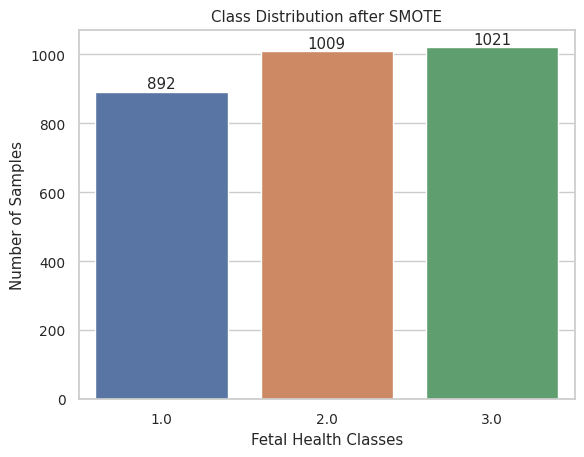

In [ ]:


smote_enn = SMOTEENN(random_state=42)
X_train, y_train = smote_enn.fit_resample(X_train, y_train)
df_train = pd.concat([X_train, pd.Series(y_train, name='fetal_health')], axis=1)

ax = sns.countplot(data= df_train, x = 'fetal_health',palette='deep')
ax.bar_label(ax.containers[0])
plt.xlabel('Fetal Health Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution after SMOTE')
plt.savefig("distribution_after_smote.svg")
plt.show()

## Scaling Data

In the dataset, there is a substantial variations in the ranges of values across different features. Consequently, a scaling operation becomes imperative. To address this, we applied StandardScaler to normalize all features and align their values within a consistent range.

This step is crucial due to the notable differences in magnitudes among the features. Normalizing the data ensures a more effective training of the machine learning model, preventing certain features from disproportionately influencing the model due to their disparate scales.

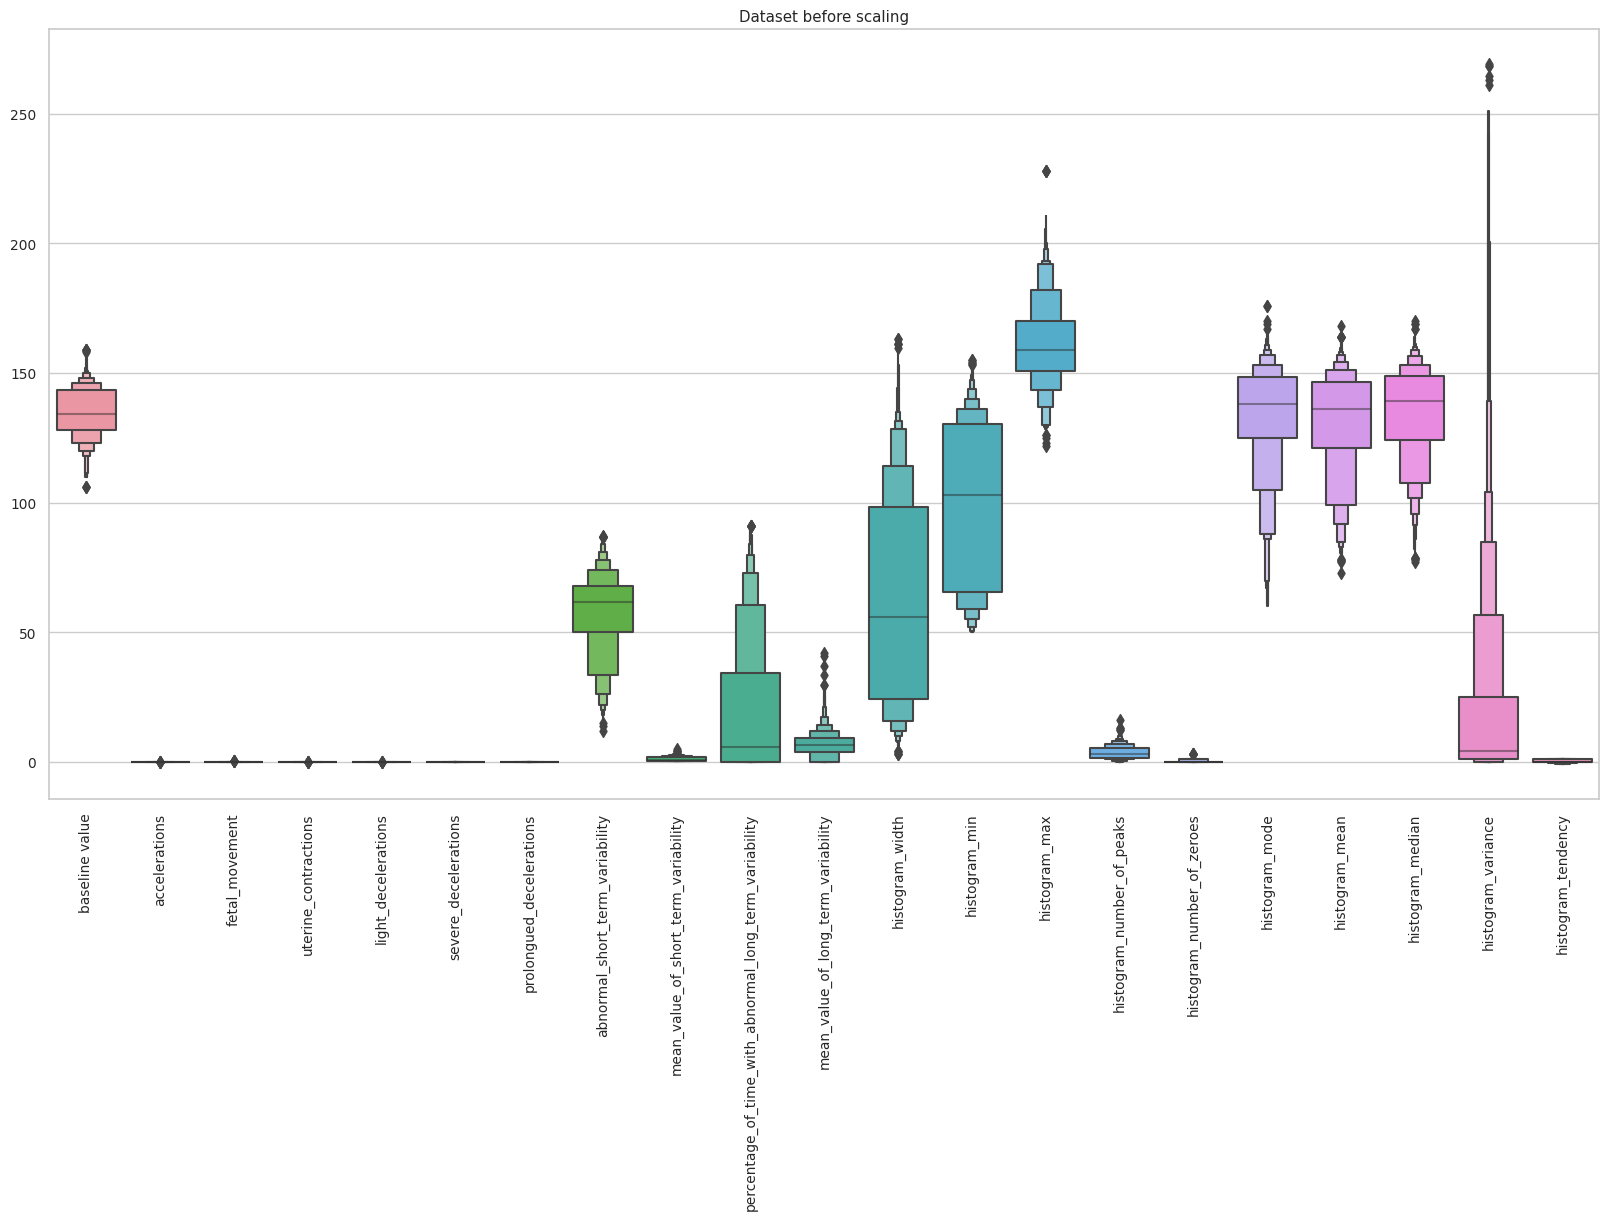

In [ ]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = df_train.drop(["fetal_health"],axis=1))
plt.xticks(rotation=90)
plt.title('Dataset before scaling')
plt.show()

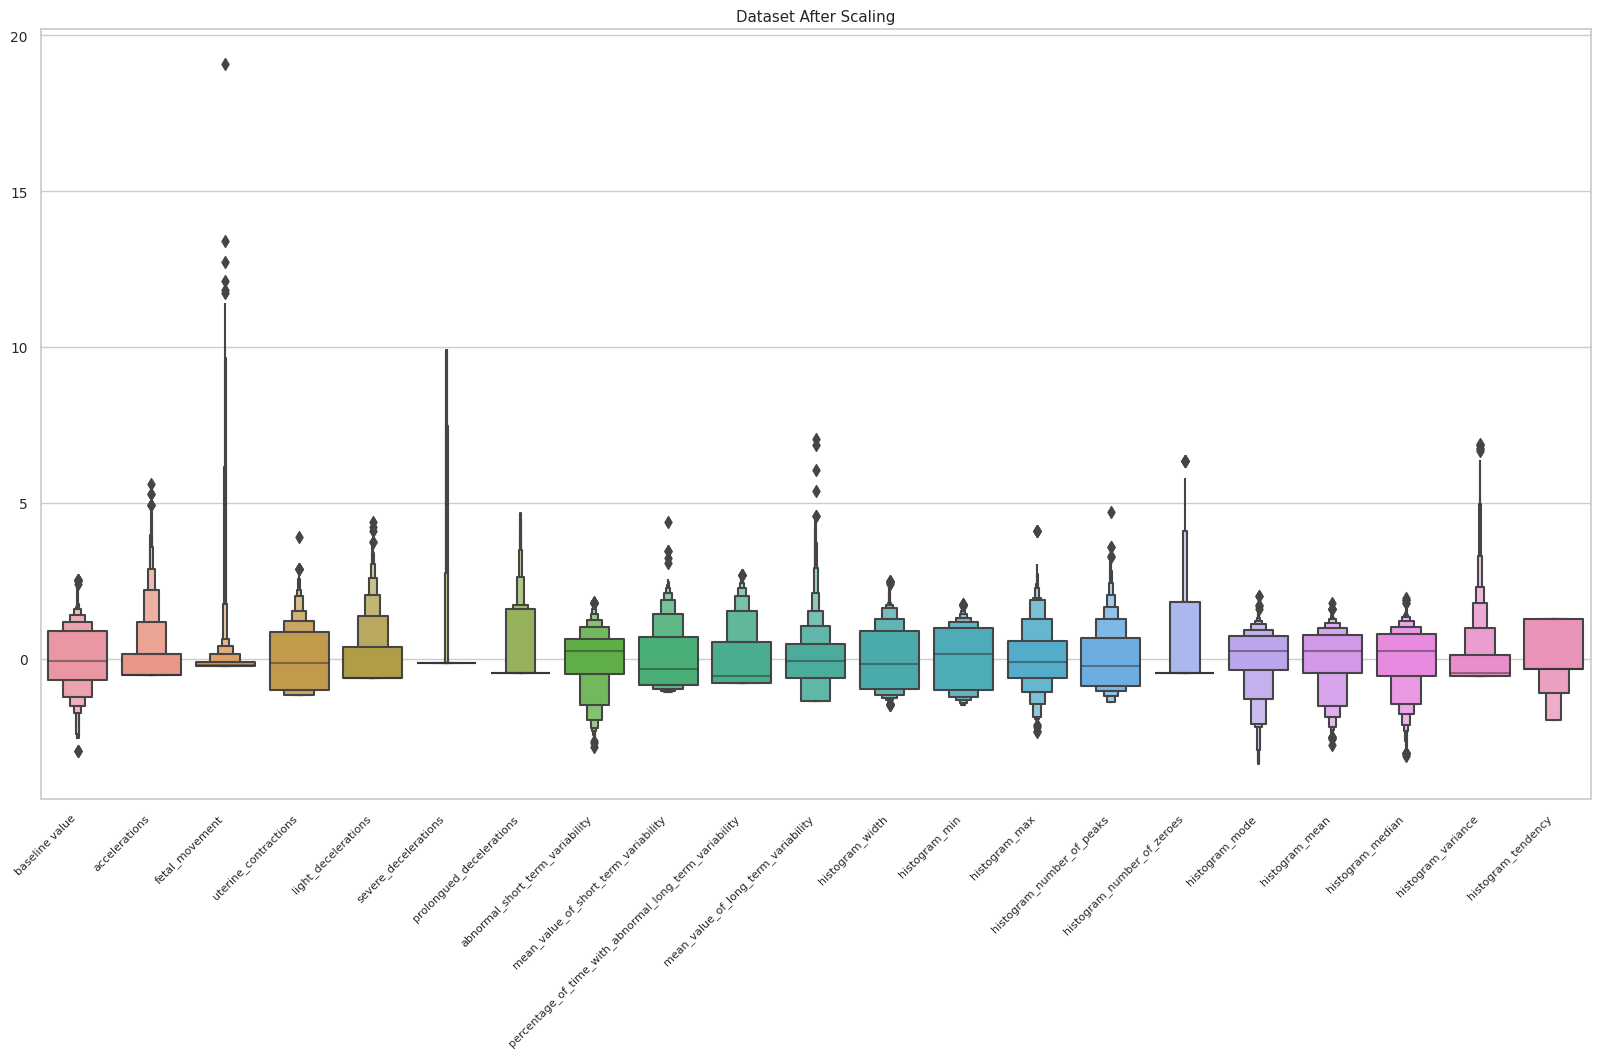

In [ ]:
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
df_train = X_train.copy()
df_train['fetal_health'] = y_train

X_test = pd.DataFrame(sc.transform(X_test), columns=X_train.columns)
df_test = X_test.copy()
df_test['fetal_health'] = y_test

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Transform the target variable labels since XGBoost expects values from 0 upwards
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

plt.figure(figsize=(20, 10))
sns.boxenplot(data=X_train)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.title('Dataset After Scaling')
plt.show()


## Feature Selection

### High Correlation features remotion

In-depth analysis was conducted on the correlation among various features in the dataset, both among themselves and with the 'fetal_health' label, aiming to identify highly correlated feature pairs that could be considered for removal.

In [ ]:
corr_matrix = X_train.corr()
df_high_corr = pd.DataFrame(columns=['Variable Pair', 'Correlation Value'])

# Identify pairs with correlation between 0.7 and 1
correlation_threshold = 0.7

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        correlation_value = corr_matrix.iloc[i, j]
        if correlation_threshold <= abs(correlation_value) < 1.0:
            pair = (corr_matrix.columns[i], corr_matrix.columns[j])
            new_row = {'Variable Pair': pair, 'Correlation Value': correlation_value}
            df_high_corr = pd.concat([df_high_corr, pd.DataFrame([new_row])], ignore_index=True)

# Sort the DataFrame by correlation values
df_high_corr = df_high_corr.sort_values(by='Correlation Value', ascending=False)

# Display the DataFrame with variable pairs and correlation values
print(df_high_corr)

                                        Variable Pair  Correlation Value
12                 (histogram_mean, histogram_median)           0.971873
11                 (histogram_mode, histogram_median)           0.940217
10                   (histogram_mode, histogram_mean)           0.916442
8        (histogram_width, histogram_number_of_peaks)           0.784717
4   (mean_value_of_short_term_variability, histogr...           0.774191
2                  (baseline value, histogram_median)           0.756013
1                    (baseline value, histogram_mean)           0.711289
0                    (baseline value, histogram_mode)           0.706816
6   (mean_value_of_short_term_variability, histogr...          -0.714600
9          (histogram_min, histogram_number_of_peaks)          -0.722403
3          (prolongued_decelerations, histogram_mean)          -0.725588
5   (mean_value_of_short_term_variability, histogr...          -0.747416
7                    (histogram_width, histogram_mi

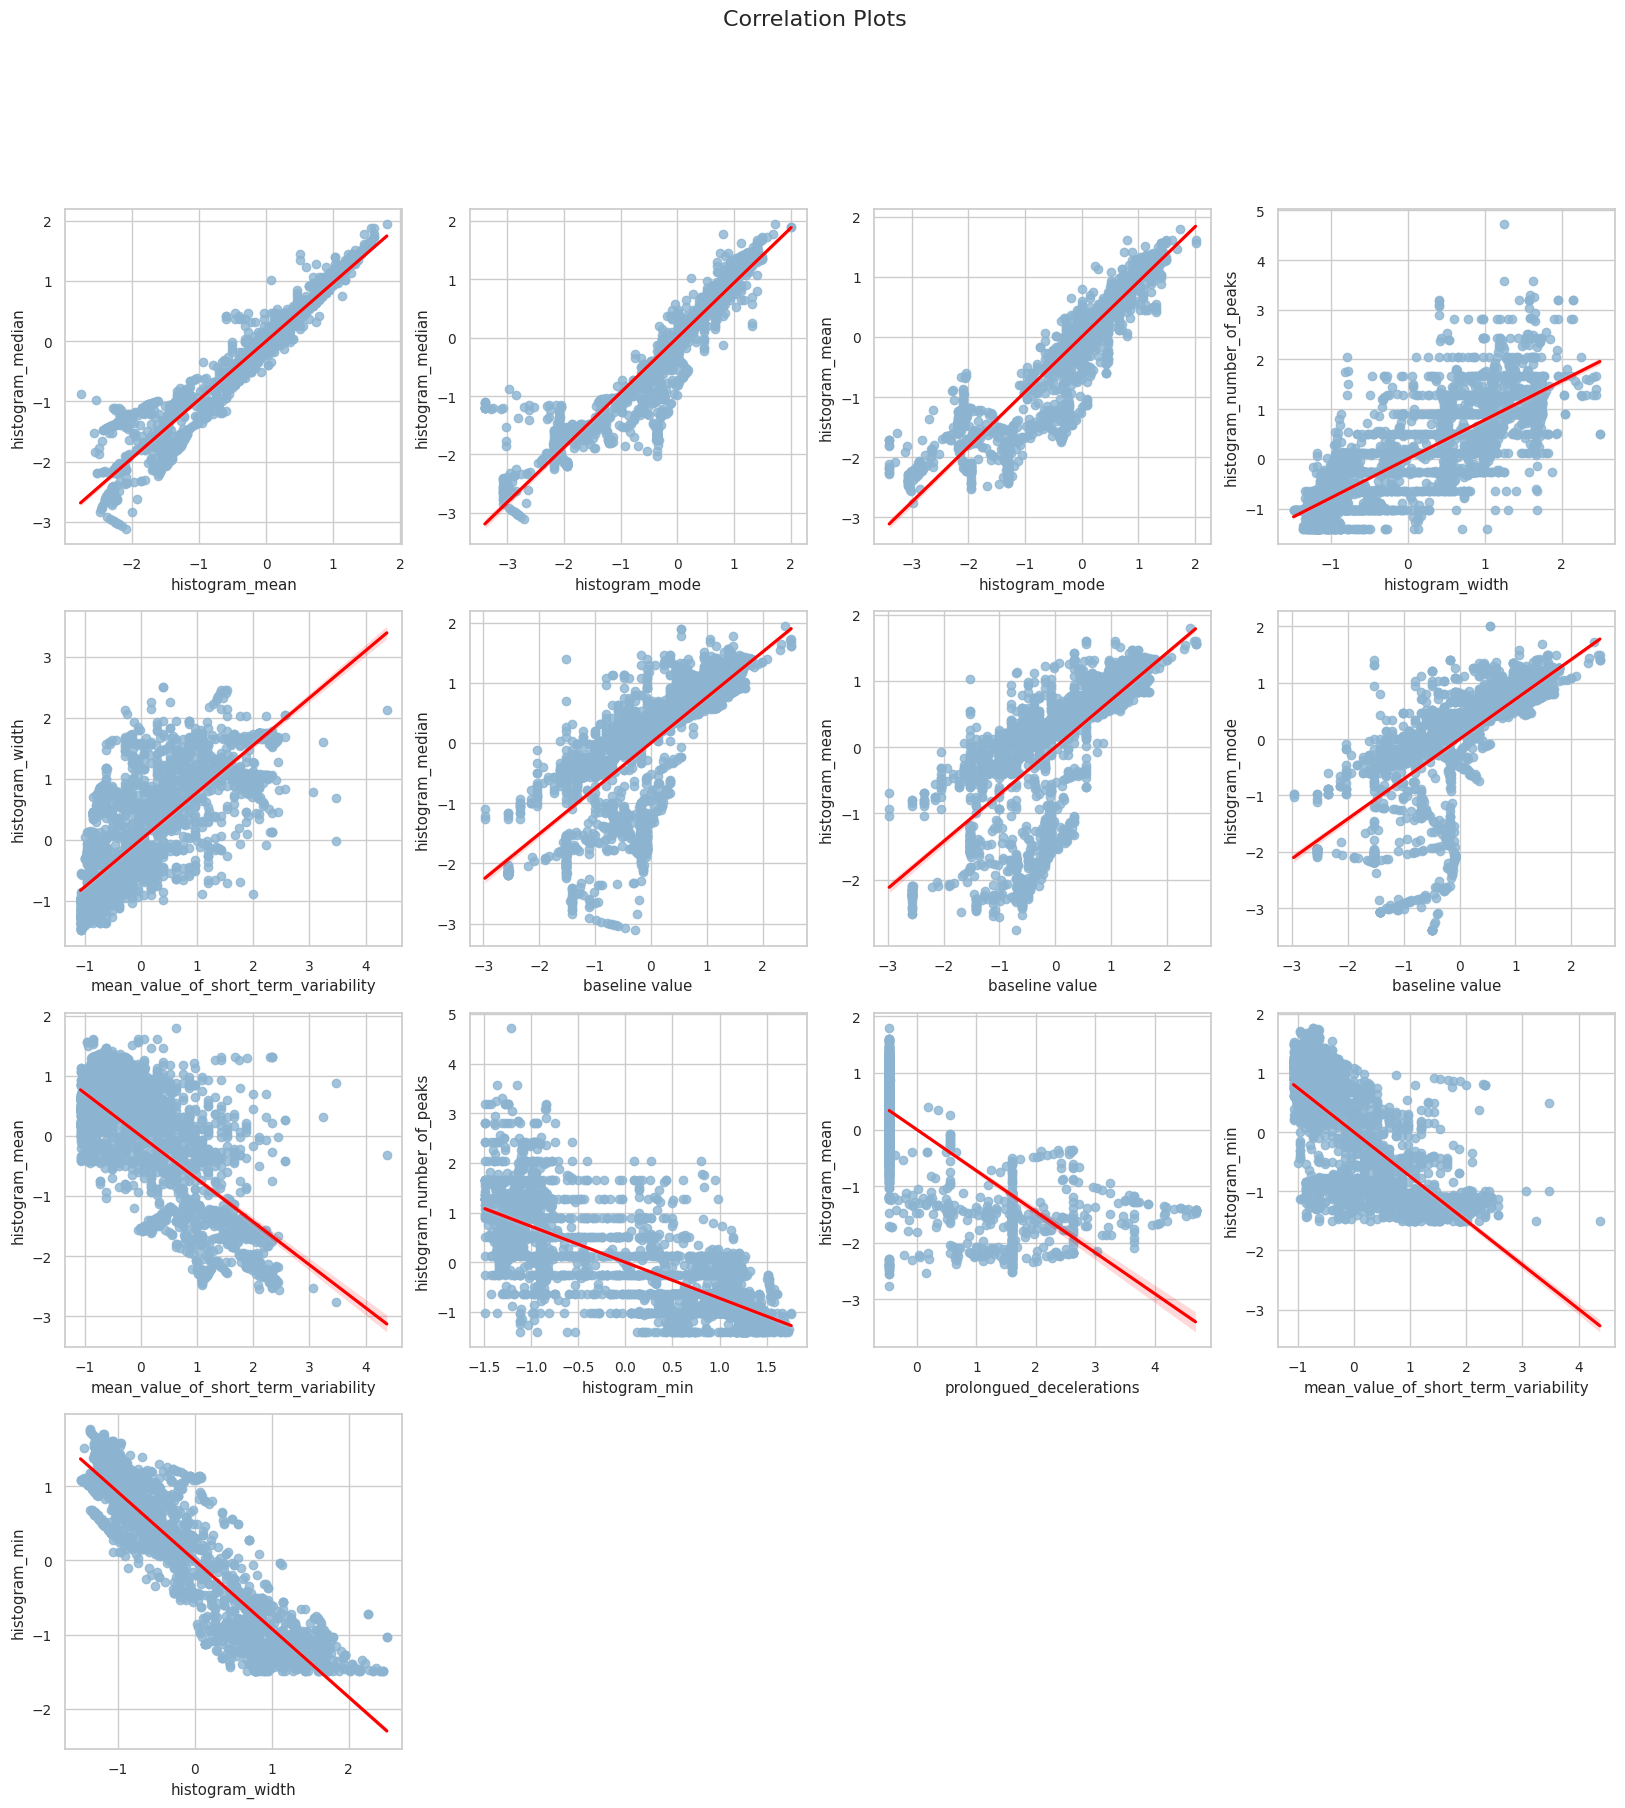

In [ ]:
plt.figure(figsize=(20, 20))

plt.suptitle("Correlation Plots", fontsize=16)
i=1
for pair in df_high_corr['Variable Pair']:
  plt.subplot(4, 4, i)
  #regression between bmi and progression
  sns.regplot(data=X_train, x=pair[0], y=pair[1],line_kws={"color": "red"})#labeling
  plt.xlabel(pair[0])
  plt.ylabel(pair[1])
  i=i+1
plt.savefig("Correlation Features Plot")
plt.show()

In [ ]:
# Save the original number of features
original_num_features = len(X_train.columns)

# Remove variables with high correlation
for pair in df_high_corr['Variable Pair']:
    # variable_to_remove = find_min_correlation_feature(pair[0], pair[1], target_corr)
    variable_to_remove = pair[0]
    # Check if the variable is in the columns before attempting to drop it
    if variable_to_remove in X_train.columns:
        X_train = X_train.drop(variable_to_remove, axis=1)
        X_test = X_test.drop(variable_to_remove, axis=1)

# Calculate the number of features removed
num_features_removed = original_num_features - len(X_train.columns)
print(f'Number of features removed: {num_features_removed}')
print(f'Number of features remaining: {len(X_train.columns)}')

# Update DataFrames
df_train = pd.concat([X_train, pd.Series(y_train, name='fetal_health')], axis=1)
df_test = pd.concat([X_test, pd.Series(y_test, name='fetal_health')], axis=1)

Number of features removed: 7
Number of features remaining: 14


### Mutual-Information vs Chi-2

The Mutual Information is a measure that quantifies the relationship between two variables and, in the context of feature analysis, assesses how much each feature is dependent on the target variable. The distinctive feature of Mutual Information is its non-parametric nature, meaning it makes no assumptions about the distribution of the underlying data. This allows Mutual Information to capture complex and non-linear relationships between features and the target variable.

On the other hand, the Chi-Square test is a statistical tool used to determine the independence between two categorical variables. Specifically, the Chi-Square test is commonly applied to variables with a limited number of unique values, typically fewer than 10. This limitation helps identify variables that can be considered categorical and are suitable for the application of the Chi-Square test.

In [ ]:
# Select the best categorical features for the Chi-Square method
select_chi2 = SelectKBest(score_func=chi2, k=4)
select_chi2.fit_transform(abs(X_train), y_train)

# Calculate the Chi-Square scores
chi2_scores = select_chi2.scores_

# Create a DataFrame for the Chi-Square scores and their corresponding columns
chi2_df = pd.DataFrame({'Feature': X_train.columns, 'Chi2 Score': chi2_scores})

# Sort the DataFrame based on Chi-Square scores in descending order
chi2_df = chi2_df.sort_values(by='Chi2 Score', ascending=False)

In [ ]:
# Select the best features for Mutual Information
select_MuInfo = SelectKBest(score_func=mutual_info_classif, k=4)
select_MuInfo.fit_transform(abs(X_train), y_train)
selected_mask_MuInfo = select_MuInfo.get_support()

# Decide to display only the top 4 variables with the highest scores
# Calculate the Mutual Information scores for the variables
MuInfo_scores = select_MuInfo.scores_

# Create a DataFrame for the Mutual Information scores and their corresponding columns
MuInfo_df = pd.DataFrame({'Feature': X_train.columns, 'MuInfo Score': MuInfo_scores})

# Sort the DataFrame based on Mutual Information scores in descending order
MuInfo_df = MuInfo_df.sort_values(by='MuInfo Score', ascending=False)

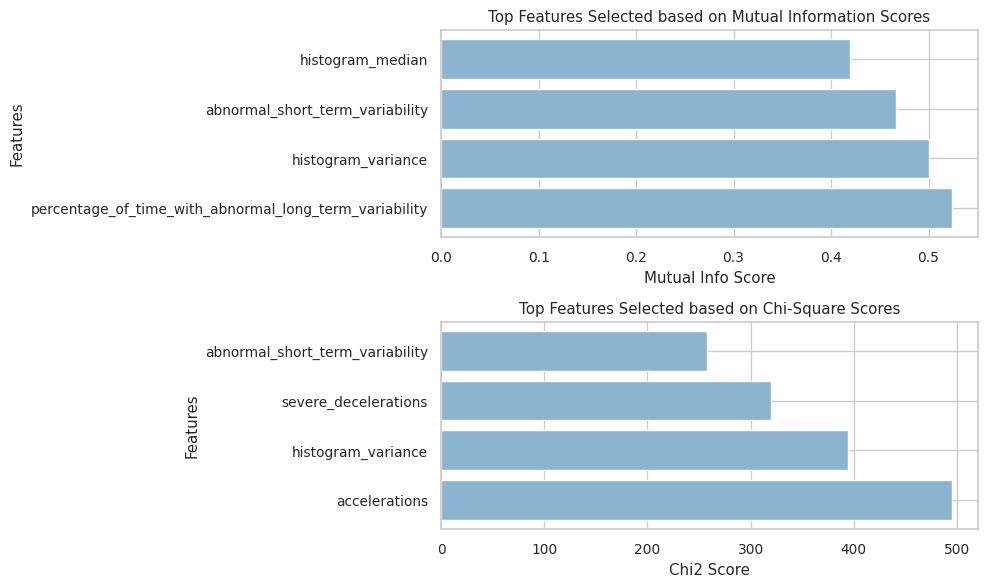

In [ ]:
# Select the top 4 columns with the highest Chi-Square scores
top_4_features_chi2 = chi2_df.head(4)
sorted_indices_chi2 = np.argsort(chi2_scores)[::-1]

# Select the top 4 columns with the highest Mutual Information scores
top_4_features_MuInfo = MuInfo_df.head(4)
sorted_indices_MuInfo = np.argsort(MuInfo_scores)[::-1]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Horizontal bar chart for Mutual Information scores
ax1.barh(top_4_features_MuInfo['Feature'], top_4_features_MuInfo['MuInfo Score'])
ax1.set_xlabel('Mutual Info Score')
ax1.set_ylabel('Features')
ax1.set_title('Top Features Selected based on Mutual Information Scores')

# Horizontal bar chart for Chi-Square scores
ax2.barh(top_4_features_chi2['Feature'], top_4_features_chi2['Chi2 Score'])
ax2.set_xlabel('Chi2 Score')
ax2.set_ylabel('Features')
ax2.set_title('Top Features Selected based on Chi-Square Scores')

# Show the side-by-side bar charts
plt.tight_layout()
plt.savefig('features_selection.png')  # Save the plot with a corrected file name
plt.show()

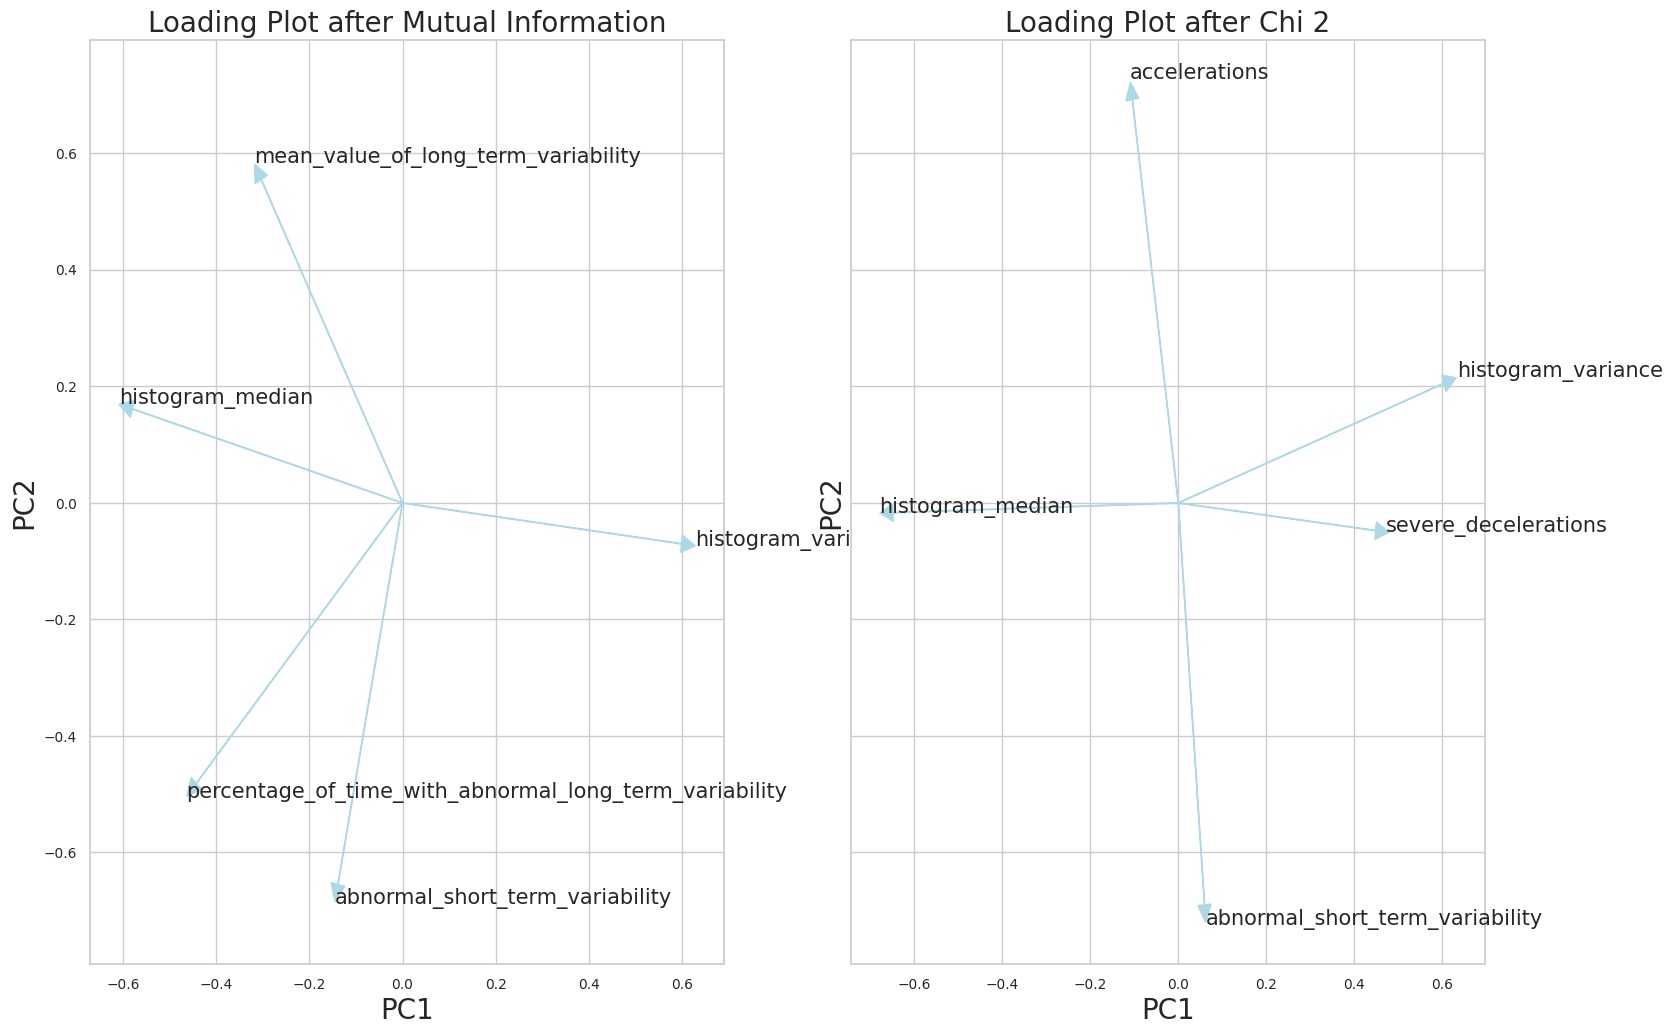

In [ ]:
# Plot for Mutual Information
pca = PCA(n_components=2)
PC1 = pca.fit_transform(df_train[MuInfo_df['Feature'][:5]])[:, 0]
PC2 = pca.fit_transform(df_train[MuInfo_df['Feature'][:5]])[:, 1]
ldngs = pca.components_

scalePC1 = 1.0 / (PC1.max() - PC1.min())
scalePC2 = 1.0 / (PC2.max() - PC2.min())
features = df_train[MuInfo_df['Feature'][:5]].columns

# Create a figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 12), sharey=True)  # Use sharey to share the y-axis


# Plot for Mutual Information
for i, feature in enumerate(features):
    axes[0].arrow(0, 0, ldngs[0, i], ldngs[1, i],
                  head_width=0.03, head_length=0.03, color='lightblue')
    axes[0].text(ldngs[0, i] * 1.05, ldngs[1, i] * 1.05,
                 feature, fontsize=15)

axes[0].set_xlabel('PC1', fontsize=20)
axes[0].set_ylabel('PC2', fontsize=20)
axes[0].set_title('Loading Plot after Mutual Information', fontsize=20)

# Plot for Chi 2
pca = PCA(n_components=2)
PC1 = pca.fit_transform(df_train[chi2_df['Feature'][:5]])[:, 0]
PC2 = pca.fit_transform(df_train[chi2_df['Feature'][:5]])[:, 1]
ldngs = pca.components_

scalePC1 = 1.0 / (PC1.max() - PC1.min())
scalePC2 = 1.0 / (PC2.max() - PC2.min())
features = df_train[chi2_df['Feature'][:5]].columns

# Plot for Chi 2
for i, feature in enumerate(features):
    axes[1].arrow(0, 0, ldngs[0, i], ldngs[1, i],
                  head_width=0.03, head_length=0.03, color='lightblue')
    axes[1].text(ldngs[0, i] * 1.05, ldngs[1, i] * 1.05,
                 feature, fontsize=15)

axes[1].set_xlabel('PC1', fontsize=20)
axes[1].set_ylabel('PC2', fontsize=20)
axes[1].set_title('Loading Plot after Chi 2', fontsize=20)

plt.savefig('log plot.svg')
plt.show()

In [ ]:
# Filter features based on Chi-Square selection
X_train_filtered = X_train[MuInfo_df['Feature'][:5]].copy()
X_test_filtered = X_test[MuInfo_df['Feature'][:5]].copy()

# Create filtered DataFrames with target variable
df_train_filtered = pd.concat([X_train_filtered, pd.Series(y_train, name='fetal_health')], axis=1)
df_test_filtered = pd.concat([X_test_filtered, pd.Series(y_test, name='fetal_health')], axis=1)

# Model Evaluation and Hyperparameter Tuning

## Model Evaluation with Cross Validation

To identify the optimal classification model among the considered options, a cross-validation procedure was conducted, employing the F1 score metric for performance evaluation. The assessed models encompass:



*   XGBoost Classifier
*   Logistic Regression
*   K-Neighbors Classfier
*   Random Forest Classifier
*   Support Vector Machine Classifier


This comprehensive evaluation allows us to gauge and compare the effectiveness of each model in the context of the specified performance metric.

In [ ]:
# Create a dictionary of standard models to evaluate {name: object}
def define_models(models=dict()):
    models['logistic'] = LogisticRegression()
    models['knn-3'] = KNeighborsClassifier(n_neighbors=3)
    # Ensemble models
    n_trees = 100
    models['rf'] = RandomForestClassifier(n_estimators=n_trees)
    models['xgb'] = xgb.XGBClassifier(random_state=42)
    models['svc'] = svm.SVC()
    return models

# Create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = [('model', model)]
    # Create a pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

# Evaluate a single model
def evaluate_model(X, y, model, metric):
    # Define StratifiedKFold
    stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    # Create the pipeline
    pipeline = make_pipeline(model)
    # Evaluate the model
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=stratified_kfold, n_jobs=-1, error_score="raise")
    return scores

# Evaluate a model and try to trap errors and hide warnings
def robust_evaluate_model(X, y, model, metric):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, metric)
    except:
        scores = None
    return scores

# Evaluate a dictionary of models {name: object}, returns {name: score}
def evaluate_models(X, y, models, metrics_list=['f1_macro', make_scorer(matthews_corrcoef, greater_is_better=True)]):
    metric_results = dict()
    for metric in metrics_list:
        results = dict()
        for name, model in models.items():
            # Evaluate the model
            scores = evaluate_model(X, y, model, metric)
            # Show process
            if scores is not None:
                # Store a result
                results[name] = scores
                mean_score, std_score = mean(scores), std(scores)
            else:
                print('>%s: error' % name)
        metric_results[metric] = results
    return metric_results

# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k, mean(v)) for k, v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g., for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores]
    scores = [results[x[0]] for x in mean_scores]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = mean(results[name]), std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i + 1, name, mean_score, std_score))

def plot_scores(results, metric, maximize=True):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k, mean(v)) for k, v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g., for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores]
    scores = [mean(results[name]) for name in names]

    bars = plt.bar(names, scores, color=colors)

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.grid(False)

    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.05, f'{score:.2f}', ha='center', va='bottom')

    plt.savefig('Models Score Overview.png')
    plt.show()

# Get the model list
models = define_models()
# Evaluate models
metric_results = evaluate_models(X_train, y_train, models)
# Summarize results
for metric_used in metric_results.keys():
    results = metric_results[metric_used]
    print('\nResults for metric', metric_used)
    summarize_results(results)


Results for metric f1_macro

Rank=1, Name=rf, Score=0.991 (+/- 0.004)
Rank=2, Name=xgb, Score=0.988 (+/- 0.006)
Rank=3, Name=knn-3, Score=0.983 (+/- 0.001)
Rank=4, Name=svc, Score=0.963 (+/- 0.007)
Rank=5, Name=logistic, Score=0.899 (+/- 0.004)

Results for metric make_scorer(matthews_corrcoef)

Rank=1, Name=rf, Score=0.984 (+/- 0.007)
Rank=2, Name=xgb, Score=0.982 (+/- 0.008)
Rank=3, Name=knn-3, Score=0.974 (+/- 0.002)
Rank=4, Name=svc, Score=0.944 (+/- 0.011)
Rank=5, Name=logistic, Score=0.845 (+/- 0.007)


Upon analysis, it becomes evident that XGBoost and Random Forest exhibit superior performance compared to other models.

## Hyperparametres Tuning

Hyperparameter tuning, or hyperparameter optimization, is the process of selecting optimal values for the hyperparameters of a machine learning model to enhance its performance. Hyperparameters are parameters external to the model that are not learned during training, unlike model parameters that are learned from the data.

So is used GridSearchCV, or Grid Search Cross-Validation, is a technique used to systematically search for the optimal hyperparameters of a machine learning model within a specified parameter grid.

In [ ]:
# dict to store the gridsearch results for each models
cv_results = dict()

In [ ]:
# parametri_grid_xgb = {
#     'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
#     'n_estimators': [30, 100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'min_child_weight': [1, 3, 5, 10],
#     'gamma': [0.01, 0.05, 0.1, 0.2 ]
# }

# # 30 minutes c.a.
# GridSearchCV_XGB = GridSearchCV(estimator= xgb.XGBClassifier(random_state=42),
#                                 param_grid= parametri_grid_xgb,
#                                 cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#                                 verbose=1,
#                                 n_jobs=1,
#                                 scoring="f1_macro",
#                                 return_train_score=True
#                                 )
# GridSearchCV_XGB.fit(X_train, y_train)

# # store result of GridSearch for XGBoost
# cv_results['xgb'] = GridSearchCV_XGB.cv_results_

# best_params_XGB = GridSearchCV_XGB.best_estimator_.get_params()

# print(f"\nBest parameter values for XGBoost model:\n")
# for param in parametri_grid_xgb.keys():
#     print(f"{param}: {best_params_XGB[param]}") # to print only features tested

# # 30 minutes c.a.
# GridSearchCV_XGB_fs = GridSearchCV(estimator= xgb.XGBClassifier(random_state=42),
#                                 param_grid= parametri_grid_xgb,
#                                 cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#                                 verbose=1,
#                                 n_jobs=1,
#                                 scoring="f1_macro",
#                                 return_train_score=True
#                                 )
# GridSearchCV_XGB_fs.fit(X_train_filtered, y_train)

# # store result of GridSearch for XGBoost with Feature selection
# cv_results['xgb_fs'] = GridSearchCV_XGB_fs.cv_results_

# best_params_XGB = GridSearchCV_XGB_fs.best_estimator_.get_params()

# print(f"\nBest parameter values for XGBoost model with feature selection:\n")
# for param in parametri_grid_xgb.keys():
#     print(f"{param}: {best_params_XGB[param]}")

Best parameter values for XGBoost model:

- learning_rate: 0.1
- n_estimators: 300
- max_depth: 5
- min_child_weight: 5
- gamma: 0.01


Best parameter values for XGBoost model with feature selection:

 - learning_rate: 0.2
 - n_estimators: 200
 - max_depth: 5
 - min_child_weight: 3
 - gamma: 0.01

In [ ]:
# parametri_grid_rf = {'bootstrap': [True, False],
#  'max_depth': [100, 150, 200, None],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 8],
#  'n_estimators': [50, 100,  200, 300, 500]}

# GridSearchCV_RF = GridSearchCV(estimator=RandomForestClassifier(),
#                                 param_grid= parametri_grid_rf,
#                                 cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="f1_macro",
#                                 return_train_score=True
#                                 )
# GridSearchCV_RF.fit(X_train, y_train)

# # store result of GridSearch for Random Forest
# cv_results['rf'] = GridSearchCV_RF.cv_results_

# best_params_RF = GridSearchCV_RF.best_estimator_.get_params()
# print(f"\nBest parameter values for Random Forest model:\n")
# for param in parametri_grid_rf.keys():
#     print(f"{param}: {best_params_RF[param]}")

# GridSearchCV_RF_fs = GridSearchCV(estimator=RandomForestClassifier(),
#                                 param_grid= parametri_grid_rf,
#                                 cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
#                                 verbose=1,
#                                 n_jobs=-1,
#                                 scoring="f1_macro",
#                                 return_train_score=True
#                                 )
# GridSearchCV_RF_fs.fit(X_train_filtered, y_train)

# # store result of GridSearch for Random Forest with feature selection
# cv_results['rf_fs'] = GridSearchCV_RF_fs.cv_results_

# best_params_RF = GridSearchCV_RF_fs.best_estimator_.get_params()

# print(f"\nBest parameter values for Random Forest model with feature selection:\n")
# for param in parametri_grid_rf.keys():
#     print(f"{param}: {best_params_RF[param]}")

Best Random Forest Parametres:
       
- bootstrap: False
- max_depth: 150
- min_samples_leaf: 1
- min_samples_split: 5
- n_estimators: 300


Best parameter values for Random Forest model with feature selection
- bootstrap: True
- max_depth: 100
- min_samples_leaf: 1
- min_samples_split: 2
- n_estimators: 500


## Visualization of GridSearch Results

In [ ]:
# # List of manually selected colors
# colors = ['red', 'blue', 'green', 'orange', 'purple']

# # Create a figure and axes object for a 2x2 grid
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# # Plot 1: XGBoost
# cv_results_xgb = cv_results['xgb']
# df_cv_results = pd.DataFrame(cv_results_xgb)
# palette_xgb = sns.color_palette("tab10", n_colors=len(df_cv_results['param_learning_rate'].unique()))
# sns.lineplot(data=df_cv_results, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate', marker='o', palette=palette_xgb, ax=axes[0, 0])
# axes[0, 0].set_title('XGBoost')
# axes[0, 0].set_xlabel('Number of Estimators (n_estimators)')
# axes[0, 0].set_ylabel('CV Average Score')
# axes[0, 0].legend(title='Learning Rate', bbox_to_anchor=(1, 1), loc='upper left')

# # Plot 2: XGBoost with Feature Selection
# cv_results_xgb_fs = cv_results['xgb_fs']
# df_cv_results = pd.DataFrame(cv_results_xgb_fs)
# palette_xgb_fs = sns.color_palette('tab10', n_colors=len(df_cv_results['param_learning_rate'].unique()))
# sns.lineplot(data=df_cv_results, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate', marker='o', palette=palette_xgb_fs, ax=axes[0, 1])
# axes[0, 1].set_title('XGBoost with Feature Selection')
# axes[0, 1].set_xlabel('Number of Estimators (n_estimators)')
# axes[0, 1].set_ylabel('CV Average Score')
# axes[0, 1].legend(title='Learning Rate', bbox_to_anchor=(1, 1), loc='upper left')

# # Plot 3: Random Forest
# cv_results_rf = cv_results['rf']
# df_cv_results = pd.DataFrame(cv_results_rf)
# palette_rf = sns.color_palette('tab10', n_colors=len(df_cv_results['param_max_depth'].unique()))
# for max_depth, color in zip(df_cv_results['param_max_depth'].unique(), palette_rf):
#     df_subset = df_cv_results[df_cv_results['param_max_depth'] == max_depth]
#     sns.lineplot(data=df_subset, x='param_n_estimators', y='mean_test_score', label=f'Max depth: {max_depth}', marker='o', color=color, ax=axes[1, 0])
# axes[1, 0].set_title('Random Forest')
# axes[1, 0].set_xlabel('Number of Estimators (n_estimators)')
# axes[1, 0].set_ylabel('CV Average Score')
# axes[1, 0].legend(title='Max depth', bbox_to_anchor=(1, 1), loc='upper left')

# # Plot 4: Random Forest with Feature Selection
# cv_results_rf_fs = cv_results['rf_fs']
# df_cv_results = pd.DataFrame(cv_results_rf_fs)
# palette_rf_fs = sns.color_palette('tab10', n_colors=len(df_cv_results['param_max_depth'].unique()))
# for max_depth, color in zip(df_cv_results['param_max_depth'].unique(), palette_rf_fs):
#     df_subset = df_cv_results[df_cv_results['param_max_depth'] == max_depth]
#     sns.lineplot(data=df_subset, x='param_n_estimators', y='mean_test_score', label=f'Max depth: {max_depth}', marker='o', color=color, ax=axes[1, 1])
# axes[1, 1].set_title('Random Forest with Feature Selection')
# axes[1, 1].set_xlabel('Number of Estimators (n_estimators)')
# axes[1, 1].set_ylabel('CV Average Score')
# axes[1, 1].legend(title='Max depth', bbox_to_anchor=(1, 1), loc='upper left')

# # Adjust layout to avoid overlap
# plt.tight_layout()

# plt.savefig('GridSearch_Evaluation.svg')

# # Show the plots
# plt.show()


# Models Training

In [ ]:
# Get the model list
model_result = dict()

## Training with All Features

In [ ]:
# Create an XGBoost classifier with desired parameters
xgb_classifier = xgb.XGBClassifier(
    learning_rate= 0.1,
    n_estimators= 300,
    max_depth= 5,
    min_child_weight=5,
    gamma=0.01
)

# Train the model
xgb_classifier.fit(X_train, y_train)

# Make predictions on the test set
model_result['xgb'] = xgb_classifier.predict(X_test)

In [ ]:
# Create a Random Forest classifier with desired parameters
rf_classifier = RandomForestClassifier(
    bootstrap=False,
    max_depth=150,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=300,
    random_state=42
)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
model_result['rf'] = rf_classifier.predict(X_test)

## Training with Selected Features

In [ ]:
# Create an XGBoost classifier with desired parameters
xgb_fs_classifier = xgb.XGBClassifier(
    learning_rate= 0.2,
    n_estimators= 200,
    max_depth= 5,
    min_child_weight=3,
    gamma=0.01
)

# Train the model on the filtered training set
xgb_fs_classifier.fit(X_train_filtered, y_train)

# Make predictions on the filtered test set
model_result['xgb_fs'] = xgb_fs_classifier.predict(X_test_filtered)

In [ ]:
# Create a Random Forest classifier with desired parameters
rf_fs_classifier = RandomForestClassifier(
    bootstrap=True,
    max_depth=100,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42
)

# Train the model on the filtered training set
rf_fs_classifier.fit(X_train_filtered, y_train)

# Make predictions on the filtered test set
model_result['rf_fs'] = rf_fs_classifier.predict(X_test_filtered)

# Performance Evaluation of Classifiers

Following the optimization of parameters with GridSearchCV, it is observed that the two chosen models exhibit very similar performances, with Random Forest having a slight advantage. The reduction of features leads to a slight deterioration in performance, but compared to the benefits of feature selection (previously discussed), it can be considered acceptable.

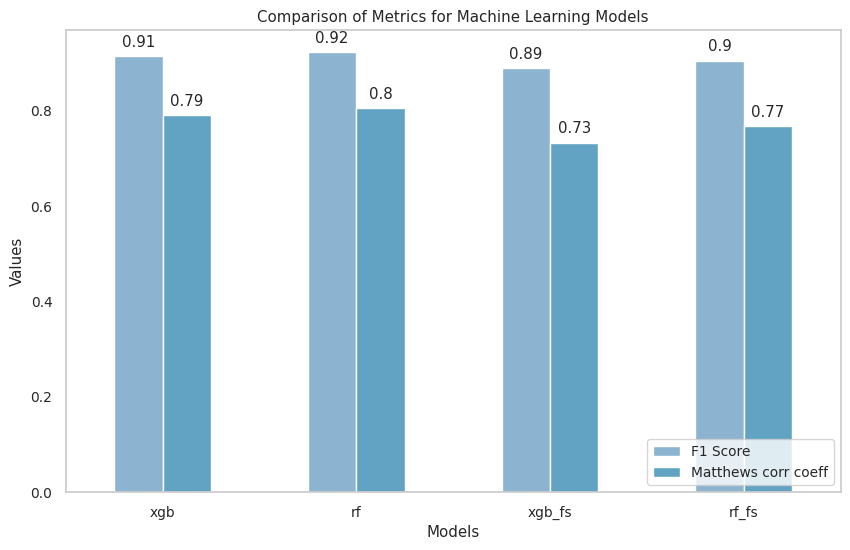

In [ ]:
metrics_score = []
for model, result in model_result.items():
    # Calculate F1 score
    f1 = f1_score(y_test, result, average='weighted')
    mcc = matthews_corrcoef(y_test, result)

    #save the model scores
    metrics_score.append([model, f1, mcc])

df_metrics = pd.DataFrame(metrics_score, columns=['Model', 'F1 Score', 'Matthews corr coeff'])

# Visualization of the bar plot
ax = df_metrics.plot(x='Model', kind='bar', figsize=(10, 6), rot=0)

# Add labels and titles
ax.set_ylabel('Values')
ax.set_xlabel('Models')
ax.set_title('Comparison of Metrics for Machine Learning Models')

# Add values above the bars
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add legend in the bottom right corner
ax.legend(loc='lower right')

plt.grid(False)

plt.savefig("models_scores.svg")
# Show the plot
plt.show()

However, upon examining the confusion matrix of the trained models, it is noticed that the XGBoost model with all features performs better in identifying diseased patients compared to Random Forest. This is a crucial characteristic in a diagnostic support system, where the system prioritizes correctly identifying individuals with illnesses. Conversely, when comparing the two models trained with only the selected attributes, the Random Forest model appears to be more accurate.

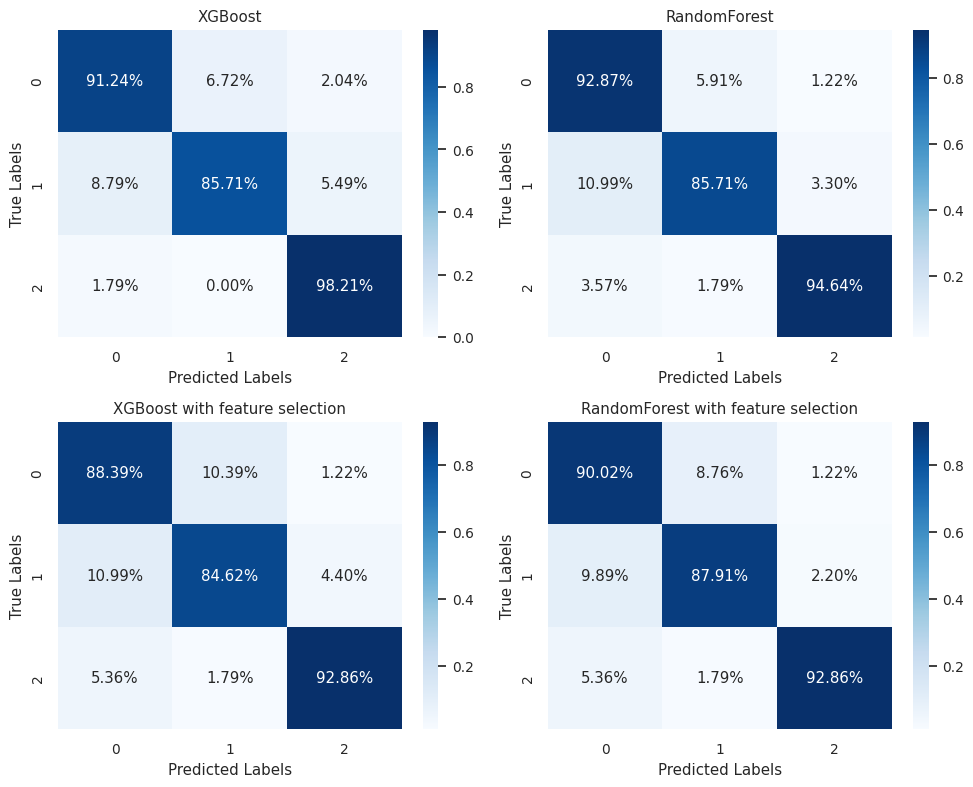

In [ ]:
# Create a 2x2 grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# List of models and their titles
models = ['xgb', 'rf', 'xgb_fs', 'rf_fs']
titles = ['XGBoost', 'RandomForest', 'XGBoost with feature selection', 'RandomForest with feature selection']

# Iterate over models and their positions in the grid
for i, model in enumerate(models):
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, model_result[model])

    # Specify the subplot position
    ax = axes[i // 2, i % 2]

    # Normalize along the rows (axis=1)
    conf_matrix_normalized = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

    # Plot the heatmap on the specified subplot
    sns.heatmap(conf_matrix_normalized,
                annot=True,
                fmt='.2%',
                cmap='Blues',
                ax=ax)

    ax.set_title(titles[i])  # Set subplot title
    ax.set_xlabel('Predicted Labels')  # Set x-axis label
    ax.set_ylabel('True Labels')  # Set y-axis label

# Add a tighter layout between subplots to avoid overlap
plt.tight_layout()
plt.savefig('Confusion_matrix.svg')
# Show the figure
plt.show()
